In [14]:
import torch
from xopt import Xopt
import yaml

YAML="""
xopt:
    dump_file: dump.yaml
generator:
    name: BayesianExploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    name: test_TNK
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [15]:
X = Xopt.from_yaml(yaml_output)


In [16]:
X.step()

for i in range(5):
    print(f'step {i}')
    X.step()

step 0
step 1
step 2
step 3
step 4


In [17]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
0,1.505994,2.305155,dummy_constant,1.505994,2.305155,6.680392,4.270610,"[1, 2, 3]",False,
1,2.829939,2.094231,dummy_constant,2.829939,2.094231,11.466248,7.970191,"[1, 2, 3]",False,
2,0.457091,0.463920,dummy_constant,0.457091,0.463920,-0.675143,0.003143,"[1, 2, 3]",False,
3,1.524066,0.612184,dummy_constant,1.524066,0.612184,1.599022,1.061297,"[1, 2, 3]",False,
4,2.251828,1.600038,dummy_constant,2.251828,1.600038,6.720476,4.278985,"[1, 2, 3]",False,
5,1.634987,0.813122,dummy_constant,1.634987,0.813122,2.289073,1.386241,"[1, 2, 3]",False,
6,1.382103,0.755336,dummy_constant,1.382103,0.755336,1.495548,0.843303,"[1, 2, 3]",False,
7,1.215826,0.674990,dummy_constant,1.215826,0.674990,0.959056,0.543028,"[1, 2, 3]",False,
8,1.143500,0.724340,dummy_constant,1.143500,0.724340,0.924736,0.464421,"[1, 2, 3]",False,
9,1.075144,0.824119,dummy_constant,1.075144,0.824119,0.885809,0.435844,"[1, 2, 3]",False,


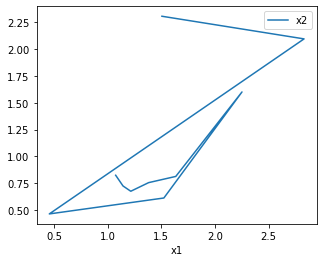

In [18]:
# plot results
ax = X.data.plot("x1","x2")
ax.set_aspect('equal')

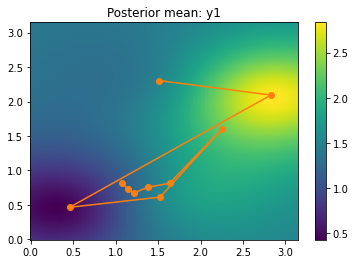

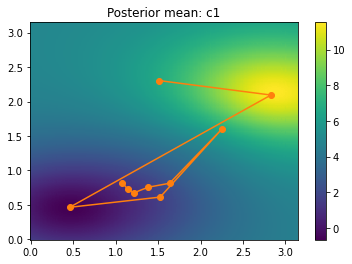

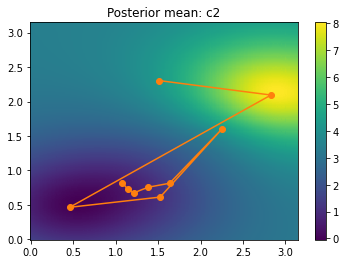

In [19]:
from matplotlib import pyplot as plt# plot model predictions
data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig,ax = plt.subplots()
        ax.plot(*data[["x1","x2"]].to_numpy().T,'o-C1')
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n,n))
        fig.colorbar(c)
        ax.set_title(f'Posterior mean: {outputs[i]}')


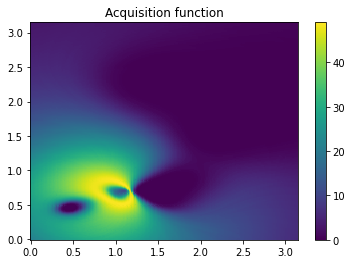

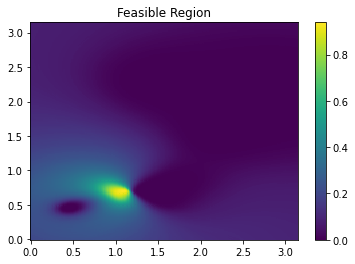

In [20]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx,yy,acq.reshape(n,n))
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    feas = feasibility(
        pts.unsqueeze(1),
        model,
        X.generator.sampler,
        X.vocs
    ).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx,yy,feas.reshape(n,n))
    fig2.colorbar(c)
    ax2.set_title('Feasible Region')